In [39]:
import sympy as sy
import numpy as np 
import pandas as pd
import scipy as sp
import math
from scipy.stats import norm, lognorm
from scipy import optimize
from matplotlib import pyplot as plt

## Problem 2.1

In [40]:
# Define a function that implements one of the three methods
def integral(f, a, b, N, method): 

    def midpoint(f, a, b, N): 
        xi = lambda i: a + ((2 * i + 1) * (b - a)) / (2 * N)    # the x-coordinate of the i-th midpoint
        return ((b - a) / N) * sum([f(xi(i)) for i in range(0, N)])
    
    def trapezoid(f, a, b, N): 
        xi = lambda i: a + i * (b - a) / (N)
        return ((b - a) / (2 * N)) * \
                (f(a) + 2* sum([f(xi(i)) for i in range(1, N)]) + f(b))
    
    def simpsons(f, a, b, N): 
        xi = lambda i: a + i * (b - a) / (2 * N)
        return ((b - a) / (6 * N)) * \
                (f(a) + 4 * sum([f(xi(i)) for i in range(1, 2 * N, 2)]) + \
                 2 * sum([f(xi(i)) for i in range(2, 2 * N - 1, 2)]) + f(b))
    
    methods = {'midpoint': midpoint, 'trapezoid': trapezoid, 'Simpsons': simpsons}
    return methods[method](f, a, b, N)

In [41]:
a, b, N = -10, 10, 10000
# Use Sympy to calculate the analytical solution 
x = sy.symbols('x')
f = 0.1 * x ** 4 + (-1.5) * x ** 3 + 0.53 * x ** 2 + 2 * x + 1
f_lam = sy.lambdify(x, f)
exact_value = sy.integrate(f, (x, a, b))

,Result,Error
Method,,
SymPy_exact,4373.33333333333,0
midpoint,4373.33319646663,0.000136866699904203
trapezoid,4373.33360706668,0.000273733351605188
Simpsons,4373.33333333332,1.63709046319127e-11


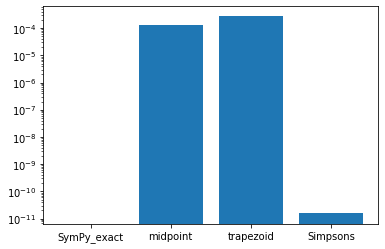

In [42]:
method_list = ['SymPy_exact', 'midpoint', 'trapezoid', 'Simpsons']
error_list = [0, ]
result_list = [exact_value, ]
for method in method_list[1:]: 
    result = integral(f_lam, a, b, N, method)
    result_list.append(result)
    error_list.append(abs(result - exact_value))

data = pd.DataFrame(data={'Method': method_list, 
                          'Result': result_list, 
                          'Error': error_list})
data.set_index('Method', inplace=True)

plt.semilogy()
plt.bar(data.index, data['Error'])
pd.set_option("display.precision", 15)
data

## Problem 2.2

In [43]:
def normal_approximate(mu, sigma, N, k): 
    z_vector = np.linspace(mu - k * sigma, mu + k * sigma, N)
    w_vector = []
    F = norm.cdf
    for i in range(N): 
        if i == 0: 
            w_vector.append(F((z_vector[i] + z_vector[i+1]) / 2, mu, sigma))
        elif i == N - 1: 
            w_vector.append(1 - F((z_vector[i-1] + z_vector[i]) / 2, mu, sigma))
        else: 
            z_min = (z_vector[i-1] + z_vector[i]) / 2
            z_max = (z_vector[i] + z_vector[i+1]) / 2
            w_vector.append(F(z_max, mu, sigma) - F(z_min, mu, sigma))
    return z_vector, np.array(w_vector)

In [44]:
mu, sigma, N, k = 0, 1, 11, 5
z_vector, w_vector = normal_approximate(mu, sigma, N, k)
pd.DataFrame(data={'z': z_vector, 'w': w_vector})

# The the weights and nodes for N = 11, k = 5 are: 

,z,w
0,-5.0,0.000003397673125
1,-4.0,0.000229231405911
2,-3.0,0.005977036246741
3,-2.0,0.060597535943082
4,-1.0,0.241730337457129
5,0.0,0.382924922548026
6,1.0,0.241730337457129
7,2.0,0.060597535943082
8,3.0,0.005977036246741
9,4.0,0.000229231405911


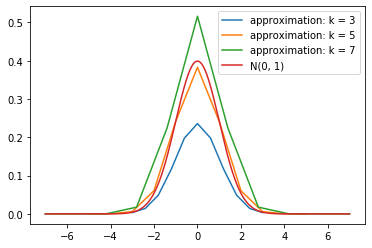

In [45]:
# Plot the approximation
mu, sigma, N = 0, 1, 11
for k in [3, 5, 7]: 
    z_vector, w_vector = normal_approximate(mu, sigma, N, k)
    plt.plot(z_vector, w_vector, label='approximation: k = ' + str(k))

# Plot the normal distribution
x_coor = np.linspace(mu - k * sigma, mu + k * sigma, 10000)
plt.plot(x_coor, norm.pdf(x_coor, mu, sigma), label='N(0, 1)')

plt.legend()

In [46]:
## Problem 2.3

In [47]:
def lognormal_approximate(mu, sigma, N, k): 
    z_vector, w_vector = normal_approximate(mu, sigma, N, k)
    return np.exp(z_vector), w_vector

In [48]:
mu, sigma, N, k = 0, 1, 11, 5
z_vector, w_vector = lognormal_approximate(mu, sigma, N, k)
pd.DataFrame(data={'z': z_vector, 'w': w_vector})

,z,w
0,0.006737946999085,0.000003397673125
1,0.018315638888734,0.000229231405911
2,0.049787068367864,0.005977036246741
3,0.135335283236613,0.060597535943082
4,0.367879441171442,0.241730337457129
5,1.000000000000000,0.382924922548026
6,2.718281828459045,0.241730337457129
7,7.389056098930650,0.060597535943082
8,20.085536923187668,0.005977036246741
9,54.598150033144236,0.000229231405911


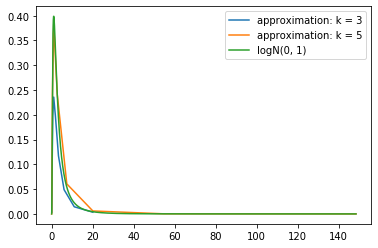

In [49]:
# Plot the approximation 
mu, sigma, N = 0, 1, 11
for k in [3, 5]: 
    z_vector, w_vector = lognormal_approximate(mu, sigma, N, k)
    plt.plot(z_vector, w_vector, label='approximation: k = ' + str(k))

# Plot the normal distribution
x_coor = (np.linspace(mu - k * sigma, mu + k * sigma, 10000))
plt.plot(np.exp(x_coor), norm.pdf(x_coor, mu, sigma), label='logN(0, 1)')

plt.legend()

## Problem 2.4

In [50]:
mu, sigma, N, k = 10.5, 0.8, 100, 5
income_level, income_density = lognormal_approximate(mu, sigma, N, k)

# Expected income is approximated by (z_vector *（scalar product) w_vector)
expect = sum(income_level * income_density)

# Calculate the exact expected value
expect_exact = np.exp(mu + (sigma ** 2) / 2)

error = abs(expect - expect_exact)
data = pd.DataFrame(data={'Approximated': [expect], 
                          'Exact': [expect_exact], 
                          'Error': [error]}, index=['Expected Income ($)'])
data

,Approximated,Exact,Error
Expected Income ($),50024.596956986446457,50011.087008521753887,13.50994846469257


## Problem 3.1

In [51]:
def gaussian(f, a, b, N): 
    init_guess = [a+i*(b-a)/(N-1) for i in range(N)] + [1/N] * N

    def equations(vars): 
        x = vars[:N]
        w = vars[N:]
        equation_list = []
        for i in range(2 * N): 
            equation_list.append(sum([w[j] * (x[j] ** i) for j in range(N)]) - (1 / (i + 1)) * (b ** (i+1) - a ** (i+1)))
        return equation_list

    result = optimize.root(equations, init_guess).x
    x_result = result[:N]
    w_result = result[N:]
    
    approximation = 0
    for i in range(N): 
        approximation += w_result[i] * f(x_result[i])
    
    return approximation

In [52]:
gaussian_result = gaussian(f_lam, -10, 10, 3)
gaussian_error = abs(gaussian_result - exact_value)
print('Gaussian approximation: ', gaussian_result)
print('Gaussian error', gaussian_error)
simpson_result = integral(f_lam, -10, 10, 100, 'Simpsons')
simpson_error = abs(simpson_result - exact_value)
print('Simpson: ', simpson_result)
print('Simpson error (N=100): ', simpson_error)
print('Gaussian error < Simpson error: ', gaussian_error < simpson_error)

Gaussian approximation:  4373.333333277765
Gaussian error 5.55673977942206e-8
Simpson:  4373.33336
Simpson error (N=100):  2.66666675088345e-5
Gaussian error < Simpson error:  True


## Problem 3.2

In [53]:
scipyquad_result = sp.integrate.quad(f_lam, -10, 10)[0]
scipyquad_error = abs(scipyquad_result - exact_value)
print('scipy.integrate.quad_result: ', scipyquad_result)
print('scipy.integrate.quad_error: ', scipyquad_error)
print('scipy.integrate.quad_error < Gaussian error: ', scipyquad_error < gaussian_error)

scipy.integrate.quad_result:  4373.333333333334
scipy.integrate.quad_error:  1.81898940354586e-12
scipy.integrate.quad_error < Gaussian error:  True


## Problem 4

In [65]:
np.random.seed(25)

In [96]:
def monte_carlo_integrate(g, omega, N): 
    # Generate random numbers within the domain and calculate the volume of omega
    area = 1 # initial value
    rv = dict()
    for var, domain in enumerate(omega): 
        area *= domain[1] - domain[0]
        rv[var] = np.random.uniform(domain[0], domain[1], N)
    args = list(zip(*[rv[var] for var in range(len(omega))]))

    # Calculate the function value at each point
    func_value_list = [g(*arg) for arg in args]

    return area * sum(func_value_list) / N

def pi_func(x, y): 
    if x ** 2 + y ** 2 <= 1: 
        return 1
    else: 
        return 0

np.random.seed(25)
monte_carlo_integrate(pi_func, [[-1, 1], [-1, 1]], 100)

3.16

In [97]:
# Find the smallest number of random draws
i = 0
np.random.seed(25)
while True: 
    i += 1
    result = monte_carlo_integrate(pi_func, [[-1, 1], [-1, 1]], i)
    if round(result, 4) == 3.1415: 
        print('The smallest number of random draws that mathes pi to the 4th decimal is: ', i)
        print('The approximation is: ', result)
        break

The smallest number of random draws that mathes pi to the 4th decimal is:  615
The approximation is:  3.1414634146341465


## Problem 4.2

In [62]:
# Define a function that returns the n-th vector of one of the four equidistributed sequences

def equi_query(n, d, sequence_name): 

    def isPrime(n):
        '''
        credit to: @rickecon
        '''
        for i in range(2, int(np.sqrt(n) + 1)):
            if n % i == 0:
                return False

        return True
    def primes_ascend(N, min_val=2):
        '''
        credit to: @rickecon
        '''
        primes_vec = np.zeros(N, dtype=int)
        MinIsEven = 1 - min_val % 2
        MinIsGrtrThn2 = min_val > 2
        curr_prime_ind = 0
        if not MinIsGrtrThn2:
            i = 2
            curr_prime_ind += 1
            primes_vec[0] = i
        i = min(3, min_val + (MinIsEven * 1))
        while curr_prime_ind < N:
            if isPrime(i):
                curr_prime_ind += 1
                primes_vec[curr_prime_ind - 1] = i
            i += 2

        return primes_vec
    
    def weyl(n, d): 
        return [math.modf(n * (primes_ascend(d)[s - 1] ** (1/2)))[0] for s in range(1, d + 1)]

    def haber(n, d): 
        return [math.modf((n * (n + 1)) / 2 * (primes_ascend(d)[s - 1] ** (1/2)))[0] for s in range(1, d + 1)]

    def niederreiter(n, d): 
        return [math.modf(n * (2 ** (s / (n+1))))[0] for s in range(1, d + 1)]

    def baker(n, d): 
        return [math.modf(n * np.exp(1 / s))[0] for s in range(1, d + 1)]

    sequence_dict = {'Weyl': weyl, 'Haber': haber, 'Niederreiter': niederreiter, 'Baker': baker}

    return sequence_dict[sequence_name](n, d)

In [63]:
# Test for the 5 the element of a 3-dimentional sequence
i, d = 5, 3
for sequence in ['Weyl', 'Haber', 'Niederreiter', 'Baker']: 
    print(f'The {i}th element of a {d}-dimentional {sequence} sequence is: \n', equi_query(5, 3, sequence))

The 5th element of a 3-dimentional Weyl sequence is: 
 [0.0710678118654755, 0.6602540378443855, 0.18033988749894903]
The 5th element of a 3-dimentional Haber sequence is: 
 [0.21320343559642652, 0.9807621135331566, 0.5410196624968506]
The 5th element of a 3-dimentional Niederreiter sequence is: 
 [0.6123102415468651, 0.2996052494743662, 0.0710678118654755]
The 5th element of a 3-dimentional Baker sequence is: 
 [0.591409142295225, 0.24360635350064186, 0.9780621254304478]


## Problem 4.3

In [88]:
def quasi_monte_carlo_integrate(g, omega, N, sequence_name): 

    # Generate random numbers within the domain and calculate the volume of omega
    area = 1 # initial value
    rv = []
    for var, domain in enumerate(omega): 
        area *= domain[1] - domain[0]
    rv = [equi_query(i, len(omega), sequence_name) for i in range(1, N+1)]
    
    # Calculate the function value at each point
    func_value_list = [g(*arg) for arg in rv]

    return area * sum(func_value_list) / N

def pi_func(x, y): 
    if x ** 2 + y ** 2 < 1: 
        return 1
    else: 
        return 0

In [89]:
for sequence in ['Weyl', 'Haber', 'Niederreiter', 'Baker']: 
    print(quasi_monte_carlo_integrate(pi_func, [[-1, 1], [-1, 1]], 1000, sequence))

3.112
3.14
4.0
3.132


In [98]:
# Find the smallest number of random draws
for sequence in ['Weyl', 'Haber', 'Baker', 'Niederreiter']: 
    np.random.seed(25) # reset the seed of random number generator for each iteration
    i = 0
    while True: 
        i += 1
        result = quasi_monte_carlo_integrate(pi_func, [[-1, 1], [-1, 1]], i, sequence)
        if round(result, 4) == 3.1415: 
            print(f'The smallest number of random draws for {sequence}: ', i)
            print(f'The approximation of {sequence}: ', result)
            break
        elif i >= 5000: 
            print(f'The result of {sequence} does not converge within 5000 draws. ')
            print(f'Current result of {sequence} is: ', result)
            break

The smallest number of random draws for Weyl:  1668
The approximation of Weyl:  3.1414868105515588
The smallest number of random draws for Haber:  615
The approximation of Haber:  3.1414634146341465
The smallest number of random draws for Baker:  410
The approximation of Baker:  3.1414634146341465
The result of Niederreiter does not converge within 5000 draws. 
Current result of Niederreiter is:  4.0


In [1]:
# The result depends on the seed of the random number generator. Here I have reset the seed to 25 for each simulation. 